Using device: cuda
L shape: torch.Size([10000, 10000]), L device: cuda:0


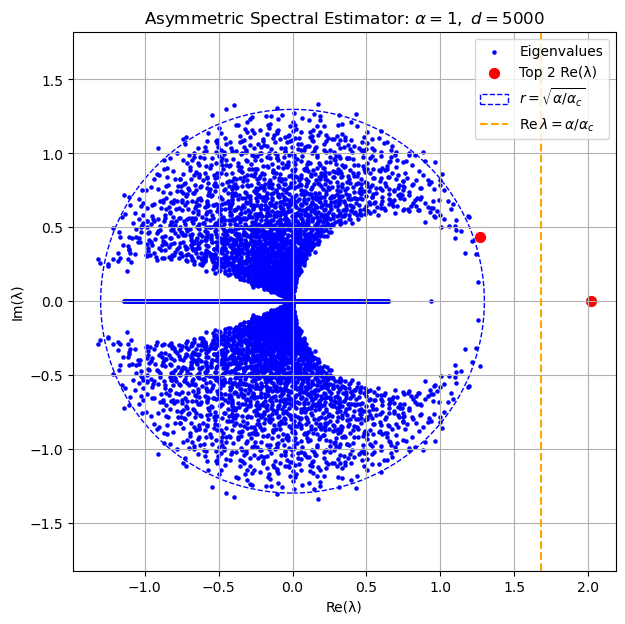

In [7]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk


# 固定随机种子（可复现性）
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# 配置参数
n = 5000  # 样本数
p = 2      # 子空间维度
alpha = 1
alpha_c = 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: 生成输入矩阵 X ∈ ℝ^{n × d}
X = torch.randn(n, d, device=device) / np.sqrt(d)

# Step 2: 构造信号子空间 W* 和观测 Z = X W*
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2  # link function: y = z1 * z2

# Step 3: 计算预处理函数 G(y) ∈ ℝ^{n × p × p}
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1 = besselk(1, abs_y)
K0 = besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0  # 数值稳定处理

# 构造 G(y): 每个样本一个 2x2 对称矩阵
G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Step 4: 构造非对称谱矩阵 L ∈ ℝ^{np × np}
XXT = X @ X.T  # shape: (n, n)
XXT.fill_diagonal_(0.0)  # 去掉主对角线

# 构造谱矩阵 L 的 (iμ, jν) 元素
A = XXT[:, :, None, None]            # shape: (n, n, 1, 1)
G_broadcast = G_y[None, :, :, :]     # shape: (1, n, p, p)
L_blocks = A * G_broadcast           # shape: (n, n, p, p)
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)  # shape: (np, np)
print(f"L shape: {L.shape}, L device: {L.device}")

# Step 5: 计算特征值（在 GPU 上）并绘图
eigvals = torch.linalg.eigvals(L)
eigvals_np = eigvals.detach().cpu().numpy()
eigvals_real = eigvals_np.real

# 获取最大两个实部的特征值索引和特征值
top2_idx = np.argsort(eigvals_real)[-2:]
top2_vals = eigvals_np[top2_idx]

# 可视化谱图
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=5, color='blue', label='Eigenvalues')
plt.scatter(top2_vals.real, top2_vals.imag, color='red', s=50, label='Top 2 Re(λ)')

# 理论谱圆半径和跳跃阈值
r = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c

circle = plt.Circle((0, 0), r, color='blue', fill=False, linestyle='--',
                    label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--',
            label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')

# 图形设置
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.title(rf'Asymmetric Spectral Estimator: $\alpha = {alpha},\ d = {d}$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


In [8]:
import torch

# Step 6: 提取谱估计器对应的主子空间（前 p 个特征向量）
eigvals_all, eigvecs_all = torch.linalg.eig(L)  # eigvecs: shape (np, np)
eigvecs_real = eigvecs_all.real  # 取实部，确保后续稳定
eigvecs_np = eigvecs_real.detach().cpu().numpy().reshape(n, p, -1)  # reshape为[n, p, p]结构

# 构造估计子空间矩阵：取对应于 top-p 跳出特征值的特征向量
top_p_idx = np.argsort(eigvals_all.real.detach().cpu().numpy())[-p:]
V_hat = eigvecs_all[:, top_p_idx].real  # shape: (n*p, p)

# 重塑为 [n, p, p_hat] 结构
V_hat = V_hat.reshape(n, p, p)  # 注意此处必须与 reshape 方法保持一致性

# 真实信号子空间 W_star
W_star_np = W_star.detach().cpu().numpy()  # shape: (d, p)

# Step 7: 计算估计矩阵 M = V_hat^T W_star（从 sample embedding 映射回原空间）
# 由于谱矩阵作用在 (X @ W*) 空间中，需计算估计特征向量在真实方向上的“投影变换”
# 我们不直接计算子空间重叠，而是基于 M 构造泛函

# 计算估计子空间与真实信号子空间的乘积投影
# 注意：为了更准确匹配，应使用正交化后的估计子空间（如必要可加入 QR 分解）

# Step 8: 定义状态演化泛函 F(M) 和 G(M)
def compute_state_functionals(M: torch.Tensor, G_y: torch.Tensor):
    """
    M: shape (p, p), 估计子空间与真实信号的对齐矩阵
    G_y: shape (n, p, p), 每个样本的 G(y) 矩阵
    """
    # M -> (p, p), G(y) -> (n, p, p)
    GM = torch.matmul(G_y, M)          # shape: (n, p, p)
    F_M = torch.mean(torch.matmul(GM, G_y), dim=0)  # shape: (p, p)

    GM_GT = torch.matmul(GM, M.T)      # shape: (n, p, p)
    G_MG_MT = torch.matmul(GM_GT, G_y)  # shape: (n, p, p)
    G_MG_MT_final = torch.mean(G_MG_MT, dim=0)  # shape: (p, p)

    return F_M, G_MG_MT_final

# 示例：使用单位矩阵作为 M（baseline 情况），或真实的 M_hat 进行评估
# 为测试 M，可用 V_hat 的投影对 W_star 构造
V_hat_flat = V_hat.reshape(n * p, p)  # (n*p, p)
XW_star = (X @ W_star).detach().cpu().numpy()  # shape: (n, p)
XW_star_flat = torch.tensor(XW_star.reshape(n * p, 1), dtype=torch.float32, device=device)
M_hat = V_hat_flat.T @ XW_star_flat / (n * p)  # 估计矩阵 M ≈ V^T W
M_hat = M_hat.squeeze()

# 评估泛函
F_M, G_M = compute_state_functionals(M_hat, G_y)

# 打印结果
print("Functional Evaluation:")
print("F(M):\n", F_M.detach().cpu().numpy())
print("G(M):\n", G_M.detach().cpu().numpy())


/tmp/ipykernel_114615/666275433.py:35: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4413.)
  GM_GT = torch.matmul(GM, M.T)      # shape: (n, p, p)


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [5000, 5000] but got: [5000, 2].